## 매매가격의 분포 분석

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

trd_group = pd.read_feather('../data/make_data/trd_group.feather')

In [17]:
# 전처리 과정
df_trd = pd.read_feather("../data/make_data/trd_preprocessed.feather")

df_trd_numeric = df_trd.select_dtypes(include=['number'])
df_trd_numeric.dropna(axis=1,inplace=True)
df_trd_numeric['시군구코드'] = df_trd_numeric['법정동코드']//100000%1000
df_trd_numeric = df_trd_numeric[[df_trd_numeric.columns[-1]]+ df_trd_numeric.columns[:-1].tolist()]
df_trd_numeric['법정동코드'] = df_trd_numeric['법정동코드']%100000
df_trd_numeric['최근거래일자'] = df_trd_numeric['최근거래일자']//100
df_trd_numeric['최근거래텀(월)'] = (df_trd_numeric['기준년월']-df_trd_numeric['최근거래일자'])//100*12 + (df_trd_numeric['기준년월']-df_trd_numeric['최근거래일자'])%100
df_trd_numeric = df_trd_numeric[df_trd_numeric.columns[:11].tolist()+[df_trd_numeric.columns[-1]]+df_trd_numeric.columns[12:-1].tolist()]
dropped_columns = list(df_trd_numeric.columns[df_trd_numeric.nunique() == 1])  # 고유값의 개수가 1인 열들 찾기
dropped_columns.append('기준년월')
df_trd_numeric.drop(columns=dropped_columns, inplace=True)    # 해당 열들 제거

In [ ]:
# 라벨 인코딩
from sklearn.preprocessing import LabelEncoder

# 1. 라벨 인코딩을 여러 변수에 적용하고 새로운 데이터프레임에 저장le = LabelEncoder()  # 각 변수별로 LabelEncoder 생성
le = LabelEncoder()
df_trd_numeric['시군구코드'] = le.fit_transform(df_trd_numeric['시군구코드'])  # 라벨 인코딩한 값만 새로운 데이터프레임에 저장

# 2. 각 변수에 대해 원래 값과 인코딩된 값의 매핑 출력 (선택사항)
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

print(f"'시군구코드' 변수의 라벨 인코딩된 값과 원래 값 매핑: {label_mapping}")

'시군구코드' 변수의 라벨 인코딩된 값과 원래 값 매핑: {110: 0, 140: 1, 170: 2, 200: 3, 215: 4, 230: 5, 260: 6, 290: 7, 305: 8, 320: 9, 350: 10, 380: 11, 410: 12, 440: 13, 470: 14, 500: 15, 530: 16, 545: 17, 560: 18, 590: 19, 620: 20, 650: 21, 680: 22, 710: 23, 740: 24}


In [31]:
# 시군구명 호출기
district = pd.read_csv('../data/other_data/법정동 기준 시군구 단위.csv')
district = district[district['시군구_코드_법정동기준']//1000==11]
district['시군구명'] = district['시군구명'].str.replace('서울 ','')
district['시군구_코드_법정동기준'] = district['시군구_코드_법정동기준']%1000

def get_dict(input_list):
    label_decoding = dict(zip(le.transform(le.classes_),le.classes_))
    gu_dict = district.set_index('시군구_코드_법정동기준')['시군구명'].to_dict()
    temp_list = [label_decoding[item] for item in input_list]
    output_list = [gu_dict[item] for item in temp_list]
    return output_list

get_dict([1,2,3,1])

['중구', '용산구', '성동구', '중구']

<Axes: title={'center': '면적코드별평균실거래가'}, xlabel='시군구코드'>

<Figure size 1200x800 with 0 Axes>

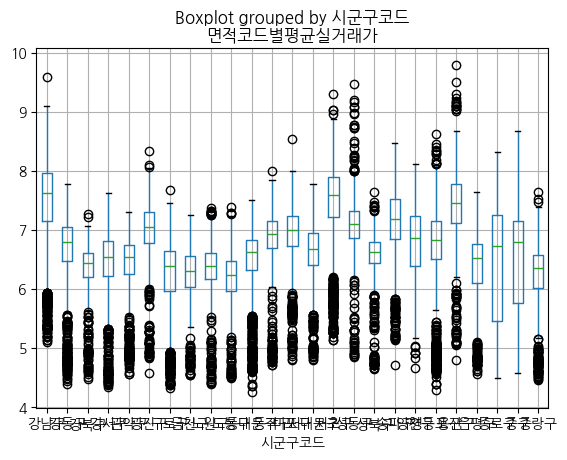

In [ ]:
# 1. 플롯 생성
trd_name = trd_group.copy()
trd_name['시군구코드'] = get_dict(trd_group['시군구코드'])

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(12, 8))  # 전체 플롯 크기 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False
trd_name.boxplot(column = '면적코드별평균실거래가',by = '시군구코드')

#### 이상치가 많아 커널밀도함수로 분포비교

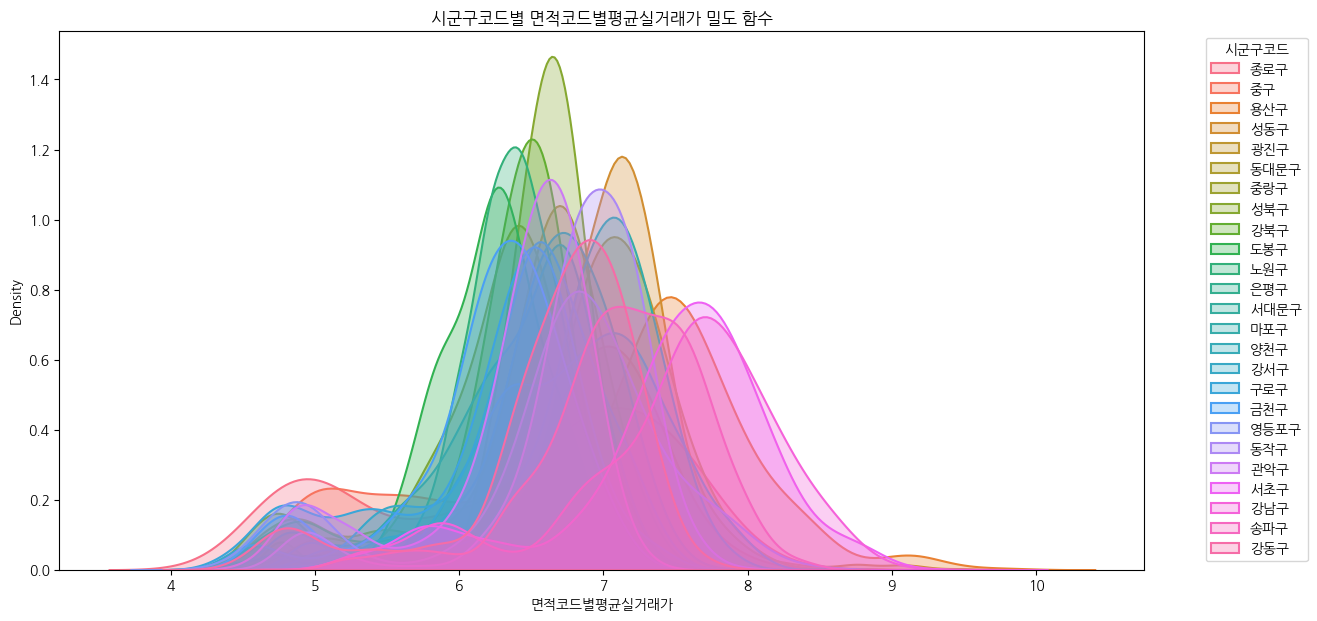

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 25개의 색상을 가진 팔레트 생성
palette = sns.color_palette("husl", 25)

plt.figure(figsize=(14, 7))
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 시군구코드별로 밀도 함수를 개별적으로 그리기
for i, code in enumerate(trd_name['시군구코드'].unique()):
    subset = trd_name[trd_name['시군구코드'] == code]
    sns.kdeplot(
        subset['면적코드별평균실거래가'], 
        label=str(code), 
        color=palette[i], 
        fill=True, 
        alpha=0.3,
        linewidth=1.5
    )

# 범례 추가 및 그래프 꾸미기
plt.xlabel("면적코드별평균실거래가")
plt.ylabel("Density")
plt.title("시군구코드별 면적코드별평균실거래가 밀도 함수")
plt.legend(title="시군구코드", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

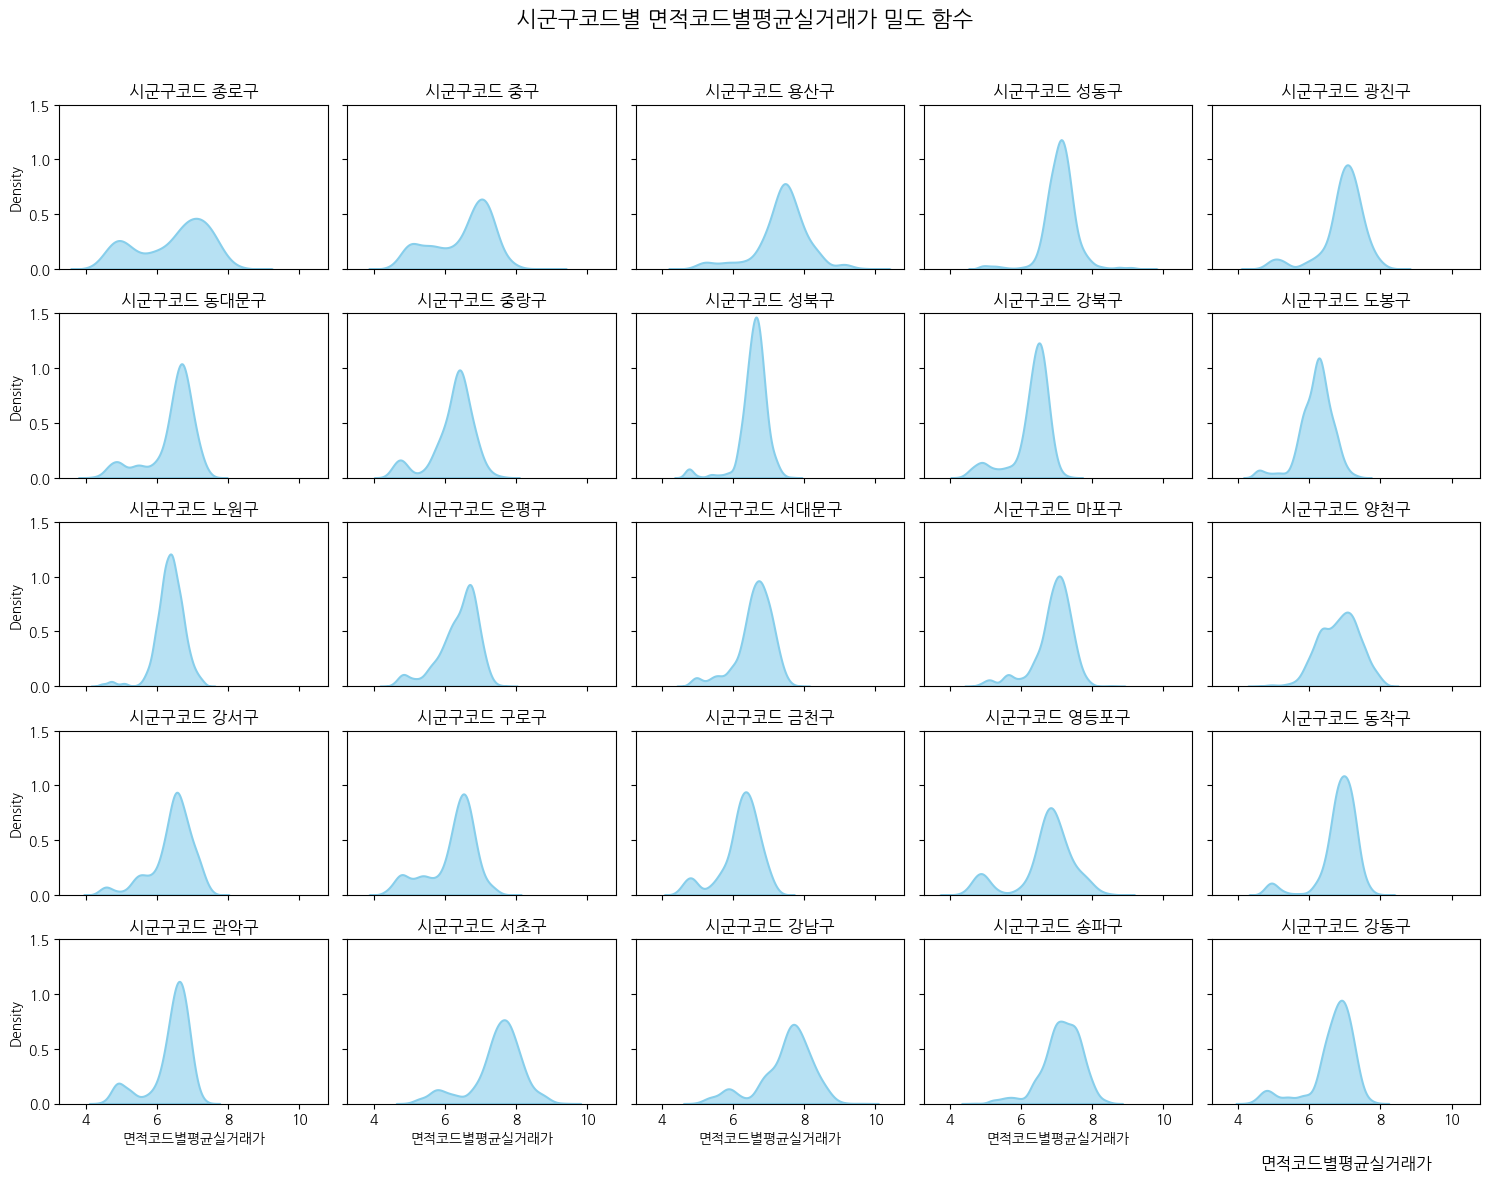

In [ ]:
# x축과 y축의 범위 설정 (공통 범위)
x_min, x_max = trd_name['면적코드별평균실거래가'].min() - 1, trd_name['면적코드별평균실거래가'].max() + 1
y_max = 1.5  # y축의 최대 범위를 적절히 설정 (밀도 최대값을 감안하여)

# subplot 생성
fig, axes = plt.subplots(5, 5, figsize=(15, 12), sharex=True, sharey=True)  # 5x5 그리드
fig.suptitle("시군구코드별 면적코드별평균실거래가 밀도 함수", fontsize=16)

# 각 시군구코드별로 subplot에 KDE plot 그리기
for i, (code, ax) in enumerate(zip(trd_name['시군구코드'].unique(), axes.flatten())):
    subset = trd_name[trd_name['시군구코드'] == code]
    sns.kdeplot(
        subset['면적코드별평균실거래가'], 
        ax=ax, 
        fill=True, 
        color="skyblue", 
        alpha=0.6, 
        linewidth=1.5
    )
    ax.set_title(f"{code}")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, y_max)

# x축과 y축 레이블 추가
plt.xlabel("면적코드별평균실거래가", fontsize=12, labelpad=20)
plt.ylabel("Density", fontsize=12, labelpad=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # 제목과 subplot 간격 조절
plt.show()

#### 용산,서초,강남에 해당하는 지역의 가격이 가장 높은 쪽에 분포되어 있음을 확인
#### 중랑,도봉,구로에 해당하는 지역의 가격이 가장 낮은 쪽에 분포되어 있음을 확인

In [7]:
trd_group.columns

Index(['면적코드', '거래량', '누적거래량', '회전율', '교차집계구유소년인구수', '교차집계구노년인구수', '인구밀도',
       '인구밀도지표', '유소년부양비', '노년부양비', '노령화지수', '지하철역까지_거리', '공원수', '공원총면적',
       '환경평가점수', '아파트단지내경사도평균값', '아파트단지내경사도최저값', '아파트단지내경사도최고값',
       '아파트단지인근경사도평균값', '아파트단지인근경사도최고값', '차량접근가능시설수', '도보접근가능시설수',
       '아파트단지내표고최저값', '아파트단지내표고최고값', '아파트단지인근표고최저값', '아파트단지인근표고최고값', 'cpi',
       '경제심리지수(원계열)', '신규_가계대출', '기준금리', '15_car', '5_walk', '10_walk',
       '20_walk', '시군구코드', '면적코드별최소실거래가', '면적코드별최대실거래가', '면적코드별평균실거래가',
       '면적코드별중위실거래가'],
      dtype='object')

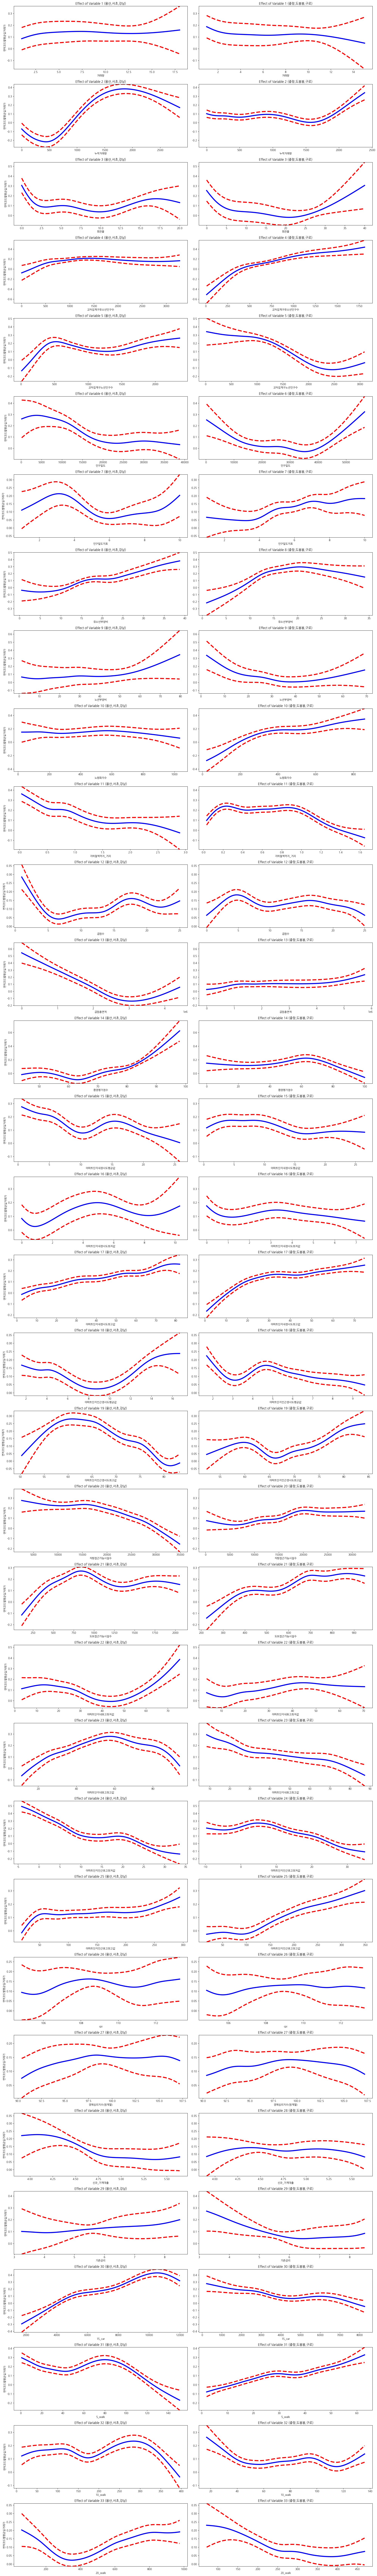

In [ ]:
import pandas as pd
from pygam import GAM, s, f
import seaborn as sns
import matplotlib.pyplot as plt
from ISLP.pygam import plot

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

a = trd_name[trd_name['시군구코드'].isin(['용산구','서초구','강남구'])].drop(columns=['시군구코드'])
a_y = a['면적코드별평균실거래가'].reset_index(drop=True)
a_x = a.drop(columns=['면적코드별최소실거래가','면적코드별최대실거래가','면적코드별평균실거래가','면적코드별중위실거래가']).reset_index(drop=True)

b = trd_name[trd_name['시군구코드'].isin(['중랑구','도봉구','구로구'])].drop(columns=['시군구코드'])
b_y = b['면적코드별평균실거래가'].reset_index(drop=True)
b_x = b.drop(columns=['면적코드별최소실거래가','면적코드별최대실거래가','면적코드별평균실거래가','면적코드별중위실거래가']).reset_index(drop=True)

# GAM 모델 구축
gam_a = GAM(s(0,lam=100)+s(1,lam=100)+s(2,lam=100)+s(3,lam=100)+s(4,lam=100)+s(5,lam=100)+s(6,lam=100)+s(7,lam=100)+s(8,lam=100)+s(9,lam=100)+s(10,lam=100)+s(11,lam=100)+s(12,lam=100)+s(13,lam=100)+s(14,lam=100)+s(15,lam=100)+s(16,lam=100)+s(17,lam=100)+s(18,lam=100)+s(19,lam=100)+s(20,lam=100)+s(21,lam=100)+s(22,lam=100)+s(23,lam=100)+s(24,lam=100)+s(25,lam=100)+s(26,lam=100)+s(27,lam=100)+s(28,lam=100)+s(29,lam=100)+s(30,lam=100)+s(31,lam=100)+s(32,lam=100)+s(33,lam=100)).fit(a_x,a_y)
gam_b = GAM(s(0,lam=100)+s(1,lam=100)+s(2,lam=100)+s(3,lam=100)+s(4,lam=100)+s(5,lam=100)+s(6,lam=100)+s(7,lam=100)+s(8,lam=100)+s(9,lam=100)+s(10,lam=100)+s(11,lam=100)+s(12,lam=100)+s(13,lam=100)+s(14,lam=100)+s(15,lam=100)+s(16,lam=100)+s(17,lam=100)+s(18,lam=100)+s(19,lam=100)+s(20,lam=100)+s(21,lam=100)+s(22,lam=100)+s(23,lam=100)+s(24,lam=100)+s(25,lam=100)+s(26,lam=100)+s(27,lam=100)+s(28,lam=100)+s(29,lam=100)+s(30,lam=100)+s(31,lam=100)+s(32,lam=100)+s(33,lam=100)).fit(b_x,b_y)

num_vars = len(a_x.columns)
fig, axes = plt.subplots(num_vars-1, 2, figsize = (20,4*num_vars), sharey=False)

for i in range(1,num_vars):
    # a 데이터의 부분 의존도 및 신뢰 구간 계산
    XX_a = gam_a.generate_X_grid(term=i)
    pdep_a, confi_a = gam_a.partial_dependence(term=i, X=XX_a, width=0.95)  # 신뢰 구간 포함
    # b 데이터의 부분 의존도 및 신뢰 구간 계산
    XX_b = gam_b.generate_X_grid(term=i)
    pdep_b, confi_b = gam_b.partial_dependence(term=i, X=XX_b, width=0.95)  # 신뢰 구간 포함
    
    # 신뢰 구간을 포함한 y축 범위 설정
    min_y = min(pdep_a.min(), confi_a.min(), pdep_b.min(), confi_b.min())
    max_y = max(pdep_a.max(), confi_a.max(), pdep_b.max(), confi_b.max())
    
    # a 데이터의 부분 의존도 (첫 번째 열)
    plot(gam_a, i, ax=axes[i-1, 0])
    axes[i-1, 0].set_ylim(min_y, max_y)  # 신뢰 구간을 포함한 y축 범위 설정
    axes[i-1, 0].set_title(f'Effect of Variable {i} (용산,서초,강남)')
    axes[i-1, 0].set_xlabel(a_x.columns[i])
    axes[i-1, 0].set_ylabel('면적코드별평균실거래가')
    
    # b 데이터의 부분 의존도 (두 번째 열)
    plot(gam_b, i, ax=axes[i-1, 1])
    axes[i-1, 1].set_ylim(min_y, max_y)  # 신뢰 구간을 포함한 y축 범위 설정
    axes[i-1, 1].set_title(f'Effect of Variable {i} (중랑,도봉봉,구로)')
    axes[i-1, 1].set_xlabel(b_x.columns[i])

plt.tight_layout()  # 그래프 간격을 자동으로 조정
plt.show()